In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os


# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [5]:

import albumentations as Alb
import pydicom as dicom
from warnings import filterwarnings
from tensorflow import keras

filterwarnings(action='ignore', category=DeprecationWarning, message='`np.bool` is a deprecated alias')

In [6]:

bounding_boxes = pd.read_csv('../input/rsna-2022-cervical-spine-fracture-detection/train_bounding_boxes.csv')
bounding_boxes

,StudyInstanceUID,x,y,width,height,slice_number
0,1.2.826.0.1.3680043.10051,219.27715,216.71419,17.30440,20.38517,133
1,1.2.826.0.1.3680043.10051,221.56460,216.71419,17.87844,25.24362,134
2,1.2.826.0.1.3680043.10051,216.82151,221.62546,27.00959,26.37454,135
3,1.2.826.0.1.3680043.10051,214.49455,215.48637,27.92726,37.51363,136
4,1.2.826.0.1.3680043.10051,214.00000,215.48637,27.00000,43.51363,137
...,...,...,...,...,...,...
7212,1.2.826.0.1.3680043.9940,297.23186,115.53983,85.18228,66.52623,140
7213,1.2.826.0.1.3680043.9940,298.00000,117.00000,86.00000,61.00000,141
7214,1.2.826.0.1.3680043.9940,298.00000,119.00000,87.00000,58.00000,142
7215,1.2.826.0.1.3680043.9940,299.00000,120.00000,89.00000,56.00000,143


In [7]:
unique_ids = list(bounding_boxes["StudyInstanceUID"].unique())
unique_ids

['1.2.826.0.1.3680043.10051',
 '1.2.826.0.1.3680043.10579',
 '1.2.826.0.1.3680043.10678',
 '1.2.826.0.1.3680043.10697',
 '1.2.826.0.1.3680043.10732',
 '1.2.826.0.1.3680043.10815',
 '1.2.826.0.1.3680043.11103',
 '1.2.826.0.1.3680043.11227',
 '1.2.826.0.1.3680043.11300',
 '1.2.826.0.1.3680043.11401',
 '1.2.826.0.1.3680043.1151',
 '1.2.826.0.1.3680043.11644',
 '1.2.826.0.1.3680043.11827',
 '1.2.826.0.1.3680043.11899',
 '1.2.826.0.1.3680043.11901',
 '1.2.826.0.1.3680043.1195',
 '1.2.826.0.1.3680043.11988',
 '1.2.826.0.1.3680043.12013',
 '1.2.826.0.1.3680043.12031',
 '1.2.826.0.1.3680043.12095',
 '1.2.826.0.1.3680043.12152',
 '1.2.826.0.1.3680043.12292',
 '1.2.826.0.1.3680043.12328',
 '1.2.826.0.1.3680043.12533',
 '1.2.826.0.1.3680043.12785',
 '1.2.826.0.1.3680043.12998',
 '1.2.826.0.1.3680043.13037',
 '1.2.826.0.1.3680043.13063',
 '1.2.826.0.1.3680043.13068',
 '1.2.826.0.1.3680043.1309',
 '1.2.826.0.1.3680043.13203',
 '1.2.826.0.1.3680043.13360',
 '1.2.826.0.1.3680043.13374',
 '1.2.826.0.1

In [8]:
unique_ids[0]

'1.2.826.0.1.3680043.10051'

In [9]:
import random
labels = []
all_dcm_files = []
dir = "../input/rsna-csfd-256x256-jpg-dataset/train_images/"

for uid in unique_ids:
    patient_scans_with_fractures = bounding_boxes[bounding_boxes['StudyInstanceUID'] == uid]
    scans_with_fractures = list(patient_scans_with_fractures['slice_number'])
    files = []
    scan_directory = dir + uid
    neg_scans = []
    count = 0
    for file in os.listdir(scan_directory):
        if file.endswith('.jpg'):
            # the list of all dicom files in the patient folder
            files.append(os.path.join(scan_directory, file))
            # get the scan number and check if it is in the list of scans with fractures
            scan_number = int(file.split('.')[0])
            # if it is in the list, append a 1 to the list of labels otherwise append a 1
            if scan_number in scans_with_fractures:
                labels.append(1)
                all_dcm_files.append(os.path.join(scan_directory, file))
                count += 1
            else:
                # labels.append(0)   
                neg_scans.append(os.path.join(scan_directory, file))# file shoul rep the full path
    sublist = random.sample(neg_scans, k = count)
    all_dcm_files.extend(sublist)
    labels.extend([0] * count)
    
sublist

['../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/5.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/181.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/10.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/8.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/29.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/154.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/188.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/7.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/128.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/11.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.9940/99.jpg',
 '../input/rsna-csfd-256x256-jp

In [10]:
len(all_dcm_files)

14434

In [11]:
from collections import Counter
Counter(labels)

Counter({1: 7217, 0: 7217})

In [12]:
all_dcm_files[0]

'../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/143.jpg'

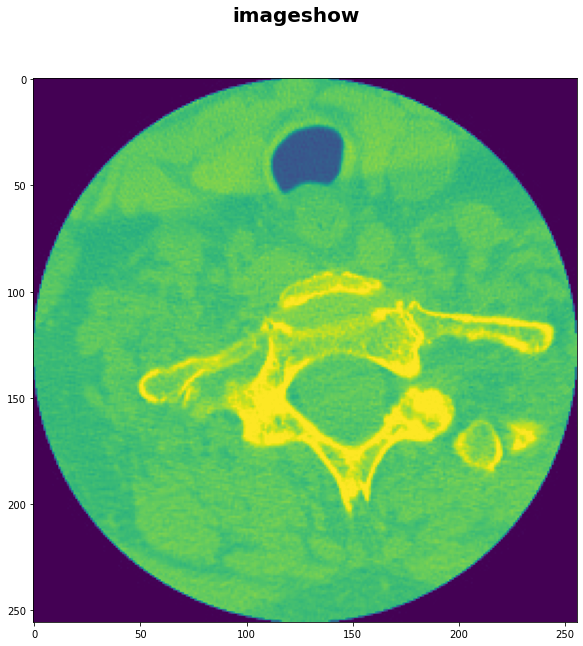

In [13]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

fig, loc = plt.subplots(nrows = 1, ncols = 1, figsize=(10,10))
fig.suptitle("imageshow", weight = "bold", size=20)

example_jpg = mpimg.imread(all_dcm_files[14433])
example_plot = plt.imshow(example_jpg)

In [14]:
from PIL import Image
im = Image.open("../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/130.jpg")


In [15]:
import tensorflow as tf
def process_scan(scan_path):
    try:
        img = Image.open(scan_path)
        data=np.array(img)
        data= tf.expand_dims(data, axis=2)
        return data
    #         print(data[10]) #ensure we are not feeding empty images
    #         data=data-np.min(data)
    #         if np.max(data) != 0:
    #             data=data/np.max(data)
    #         data=(data*255).astype(np.uint8)        
    #         return cv2.cvtColor(data.reshape(512, 512), cv2.COLOR_GRAY2RGB)
    except:
        return np.array(256,256,1)
        
    

In [16]:
singleScan = process_scan(all_dcm_files[0])

In [17]:
class DataGenerator(keras.utils.Sequence):
    'Generates data for Keras'
    def __init__(self, dicom_files, labels, batch_size, dim, n_classes, shuffle,  n_channels=1):
        'Initialization'
        self.dim = dim
        self.batch_size = batch_size
        self.labels = labels
        self.dicom_files = dicom_files
        self.n_classes = n_classes
        self.n_channels = n_channels
        self.shuffle = shuffle
        self.on_epoch_end()

    def __len__(self):
        'Denotes the number of batches per epoch'
        return int(np.floor(len(self.dicom_files) / self.batch_size))

    def __getitem__(self, index):
        'Generate one batch of data'
        # Generate indexes of the batch
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]

        dicom_files_temp = [self.dicom_files[k] for k in indexes]
        labels_temp = [self.labels[k] for k in indexes]

        # Generate data
        X, y = self.__data_generation(dicom_files_temp, labels_temp)
        
        return X, y

    def on_epoch_end(self):
        'Updates indexes after each epoch'
        self.indexes = np.arange(len(self.dicom_files))
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def __data_generation(self, dicom_files_temp, labels_temp):
        'Generates data containing batch_size samples'
        # Initialization
        X = np.empty((self.batch_size, *self.dim, self.n_channels))
        y = np.empty((self.batch_size), dtype=int)

        # Generate data
        for i, dicom_file in enumerate(dicom_files_temp):
            X[i] = process_scan(dicom_file)
            y[i] = labels_temp[i]

        return X, y

In [18]:
all_dcm_files

['../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/143.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/137.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/140.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/145.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/135.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/142.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/148.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/138.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/146.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/139.jpg',
 '../input/rsna-csfd-256x256-jpg-dataset/train_images/1.2.826.0.1.3680043.10051/141.jpg',
 '../input

In [19]:
from sklearn.model_selection import train_test_split

n_classes = 1
img_width = 256
img_height = 256

params = {'dim': (img_width, img_height),
          'batch_size': 4,
          'n_classes': n_classes,
          'shuffle': True}

# x,listidx=np.unique(all_dcm_files,return_index=True)
# indices = np.random.permutation(len(listidx))
# training_idx, test_idx = indices[:round(0.8*len(indices))], indices[round(0.8*len(indices))+1:]

# x = all_dcm_files
# y = np.array(labels)
# y.expand_dims(1)
# x_train, x_val = x[training_idx], x[test_idx]
# # THIS IS FOR LABELS
# y_train, y_val = y[training_idx], y[test_idx]
# # print("Number of samples in train and validation are %d and %d."
# #     % (x_train.shape[0], x_val.shape[0])
# #         )

x_train, x_val, y_train, y_val = train_test_split(all_dcm_files, labels, test_size=0.2, random_state=42)
training_generator = DataGenerator(x_train, y_train, **params)
val_generator = DataGenerator(x_val, y_val, **params)


In [21]:
x, y = training_generator.__getitem__(20)

In [23]:
x.shape

(4, 256, 256, 1)

In [24]:

print(y)

[1 1 1 1]


In [25]:
from keras.applications.densenet import DenseNet121
from keras.models import Model
from tensorflow.keras import layers
from tensorflow import keras


densenet = DenseNet121(
    weights=None,
    input_tensor=None,
    include_top=False,
    input_shape = (256,256,1),
    classes=1
)

output = densenet.layers[-1].output
output = keras.layers.Flatten()(output)
output = keras.layers.Dense(1,activation='sigmoid')(output)

densenet = Model(densenet.input, output)

densenet.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 1) 0                                            
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 262, 262, 1)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 128, 128, 64) 3136        zero_padding2d[0][0]             
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 128, 128, 64) 256         conv1/conv[0][0]                 
______________________________________________________________________________________________

In [ ]:
from tensorflow.keras import optimizers

# class_weights = {0: 1.,
#                  1: 9.76426264801}

metrics = [
          keras.metrics.TruePositives(name='tp'),
          keras.metrics.FalsePositives(name='fp'),
          keras.metrics.TrueNegatives(name='tn'),
          keras.metrics.FalseNegatives(name='fn'), 
          keras.metrics.BinaryAccuracy(name='accuracy'),
          keras.metrics.Precision(name='precision'),
          keras.metrics.Recall(name='recall'),
          keras.metrics.AUC(name='auc'),
          keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
        ]

adam_opt = optimizers.Adam(learning_rate = 0.0001)
densenet.compile(
    optimizer = adam_opt,
    loss = "binary_crossentropy",
    metrics=metrics,
)

checkpoint_cb = keras.callbacks.ModelCheckpoint("2d_fracturedetector_OCT13.h5", save_best_only=True)
early_stopping_cb = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)

densenet.fit(
    training_generator,
    validation_data=val_generator,
    #callbacks=[checkpoint_cb, early_stopping_cb, WandbCallback()],
    callbacks=[checkpoint_cb, early_stopping_cb],
    #class_weight=class_weights,
    epochs=300
)

